# **Resource Allocation for a Wireless Network**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
plt.style.use('seaborn-v0_8')

### Loading Data

In [3]:
df = pd.read_csv('resource_allocation.csv')
df.head()

,Time,Num_Users,Avg_User_Demand,User_Mobility,Available_Resources,SNR,Weather_Condition,Congestion_Level,Traffic_Type,QoS_Latency,QoS_Throughput,Historical_Resource_Usage,Holiday_Indicator,Resource_Allocation
0,2024-12-01 00:00:00,110,3.555545,0.302914,41.696997,39.074666,0,0.067013,2,179.903552,8.779293,10.833391,1,3.649006
1,2024-12-01 00:00:01,165,3.510071,0.441752,52.088917,37.406590,0,0.061992,0,128.392921,4.028661,10.360763,1,5.432584
2,2024-12-01 00:00:02,85,2.656181,0.511946,43.612692,41.561353,0,0.012549,0,136.201147,7.678396,5.096495,1,2.229420
3,2024-12-01 00:00:03,170,3.717454,0.622450,45.633985,42.957011,1,0.097394,1,125.846759,4.532595,13.077713,1,5.704172
4,2024-12-01 00:00:04,102,2.268687,0.753624,50.021734,45.146271,0,0.061334,0,153.906946,9.132589,14.338340,1,2.172130


In [4]:
df.shape

(10000, 14)

In [5]:
df.dtypes

Time                          object
Num_Users                      int64
Avg_User_Demand              float64
User_Mobility                float64
Available_Resources          float64
SNR                          float64
Weather_Condition              int64
Congestion_Level             float64
Traffic_Type                   int64
QoS_Latency                  float64
QoS_Throughput               float64
Historical_Resource_Usage    float64
Holiday_Indicator              int64
Resource_Allocation          float64
dtype: object

In [6]:
X = df.drop(columns=["Resource_Allocation"])
y = df["Resource_Allocation"]

### EDA

In [7]:
from scipy.stats import skew

skew_value = skew(y)
print(f"Skewness: {skew_value}") # Moderately skewed

Skewness: 0.43415742051203304


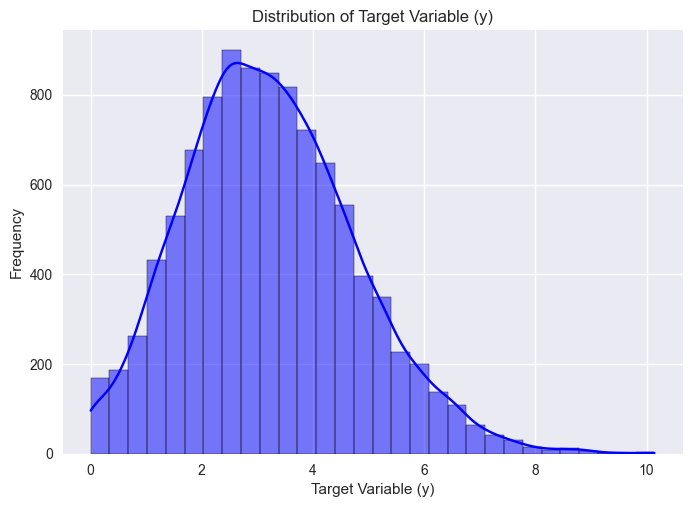

In [8]:
import seaborn as sns

sns.histplot(y, kde=True, bins=30, color="blue")
plt.title("Distribution of Target Variable (y)")
plt.xlabel("Target Variable (y)")
plt.ylabel("Frequency")
plt.show()

In [9]:
df.isna().sum()

Time                         0
Num_Users                    0
Avg_User_Demand              0
User_Mobility                0
Available_Resources          0
SNR                          0
Weather_Condition            0
Congestion_Level             0
Traffic_Type                 0
QoS_Latency                  0
QoS_Throughput               0
Historical_Resource_Usage    0
Holiday_Indicator            0
Resource_Allocation          0
dtype: int64

### Data Splitting

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Cyclic Encoding for Time feature

In [11]:
def transform(X):
    X = X.copy()
    X["Time"] = pd.to_datetime(X["Time"])
    X["hour"] = X["Time"].dt.hour
    X["day_of_week"] = X["Time"].dt.dayofweek
    X["month"] = X["Time"].dt.month

    # Cyclical Encoding
    X["hour_sin"] = np.sin(2 * np.pi * X["hour"] / 24)
    X["hour_cos"] = np.cos(2 * np.pi * X["hour"] / 24)
    X["day_sin"] = np.sin(2 * np.pi * X["day_of_week"] / 7)
    X["day_cos"] = np.cos(2 * np.pi * X["day_of_week"] / 7)
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X = X.drop(columns=["Time", "hour", "day_of_week","month"])
    return X

X_train = transform(X_train)
X_test = transform(X_test)

### Outlier Handling

In [12]:
# IQR Outlier Detection
def clip_outliers(X, features, threshold=1.5):
    X = X.copy()
    for col in features:
        if X[col].nunique() > 10:  # applying only to continuous data
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            X[col] = np.clip(X[col], lower_bound, upper_bound)
    return X

numerical_features = ["Num_Users", "Avg_User_Demand", "User_Mobility", "Available_Resources", "SNR", "Congestion_Level", "QoS_Latency", "QoS_Throughput", "Historical_Resource_Usage"]

X_train = clip_outliers(X_train, numerical_features)

### Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

### Encoding Categorical Features

In [ ]:
categorical_features = ["Weather_Condition", "Traffic_Type", "Holiday_Indicator"]

encoder = OneHotEncoder(handle_unknown="ignore")
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

In [15]:
X_train = np.hstack([X_train.drop(columns=categorical_features).values, X_train_cat.toarray()])
X_test = np.hstack([X_test.drop(columns=categorical_features).values, X_test_cat.toarray()])

In [16]:
X_train.shape

(8000, 22)

## Random Forest, Gradient Boosting, XGBoost Models

### Hyperparameter Tuning

In [17]:
# Hyperparameter Grids
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5]
}

xgb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [ ]:
# Model Initialization
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

In [ ]:
# Tuning with GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=3, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=3, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')

In [ ]:
# Fit the models
rf_grid_search.fit(X_train, y_train)
gb_grid_search.fit(X_train, y_train)
xgb_grid_search.fit(X_train, y_train)

# Best models from grid search
best_rf_model = rf_grid_search.best_estimator_
best_gb_model = gb_grid_search.best_estimator_
best_xgb_model = xgb_grid_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 162 candidates, totalling 486 fits


### Model Evaluation

In [21]:
rf_pred = best_rf_model.predict(X_test)
gb_pred = best_gb_model.predict(X_test)
xgb_pred = best_xgb_model.predict(X_test)

In [22]:
models = ['RandomForest', 'GradientBoosting', 'XGBoost']
predictions = [rf_pred, gb_pred, xgb_pred]
mae_list, mse_list, r2_list = [], [], []

for i in range(3):
    mae = mean_absolute_error(y_test, predictions[i])
    mse = mean_squared_error(y_test, predictions[i])
    r2 = r2_score(y_test, predictions[i])
    mae_list.append(mae)
    mse_list.append(mse)
    r2_list.append(r2)
    print(f'{models[i]} - MAE: {mae}, MSE: {mse}, R²: {r2}')

RandomForest - MAE: 0.07915573621233936, MSE: 0.045786262862192874, R²: 0.981854085435804
GradientBoosting - MAE: 0.08073793023621519, MSE: 0.04348056223686061, R²: 0.982767875816203
XGBoost - MAE: 0.0757255755003144, MSE: 0.04303309909408407, R²: 0.9829452134596767


In [23]:
type(y_test)

pandas.core.series.Series

### Visualizing Predictions

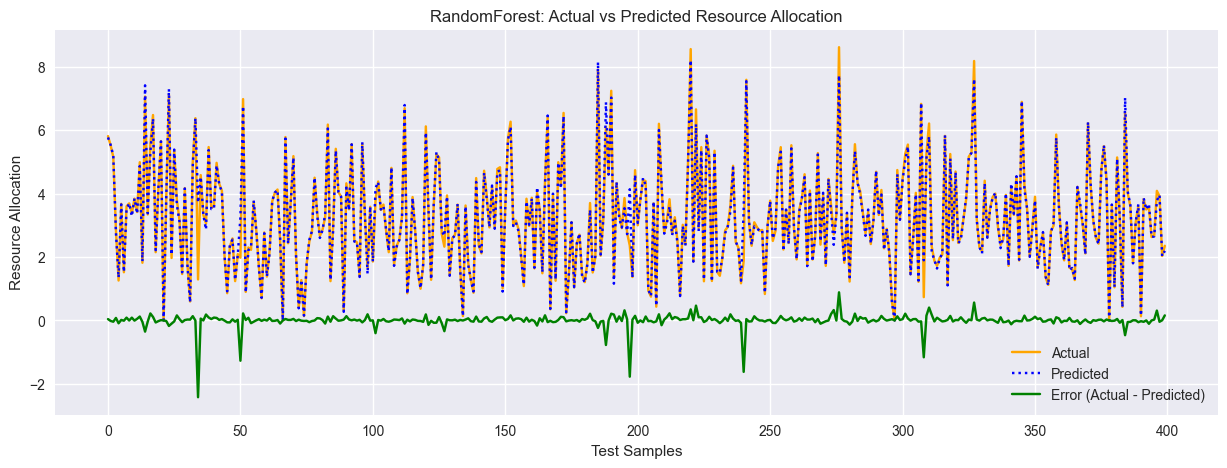

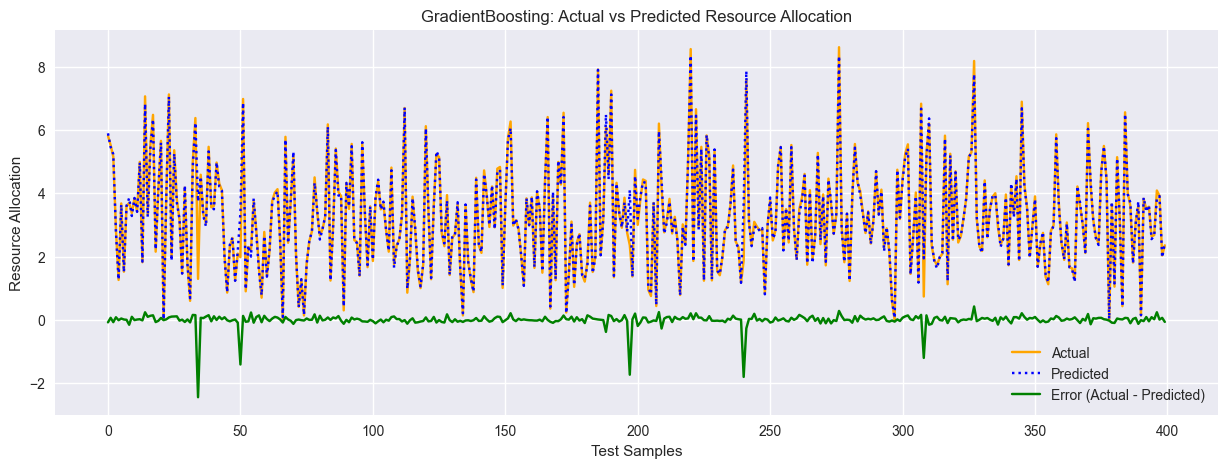

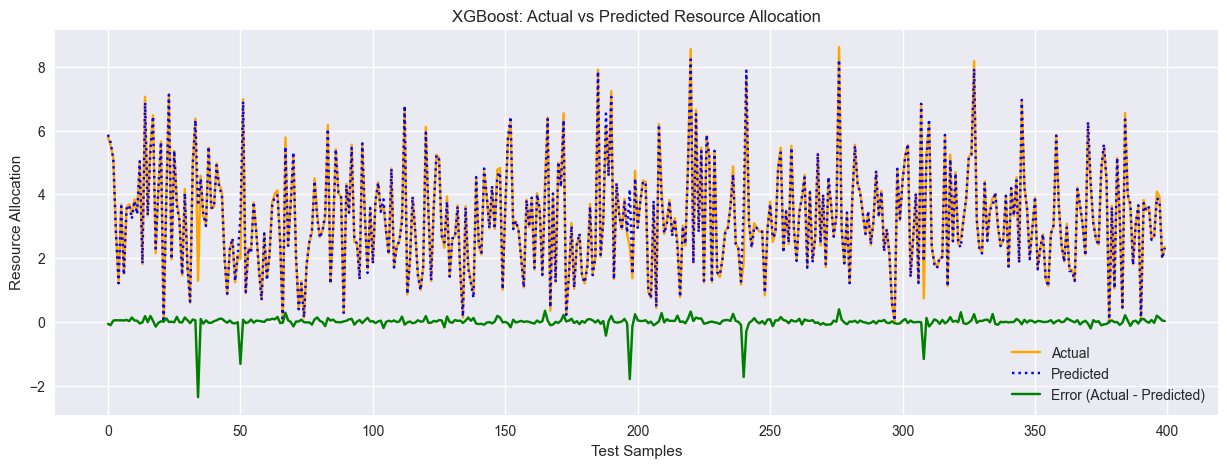

In [24]:
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()

for i in range(3):
    plt.figure(figsize=(15, 5))
    plt.plot(y_test[:400], label='Actual', color='orange')
    plt.plot(predictions[i][:400], label='Predicted', color='blue', linestyle=':')
    plt.plot(y_test[:400]-predictions[i][:400], label='Error (Actual - Predicted)', color='green')

    plt.xlabel('Test Samples')
    plt.ylabel('Resource Allocation')
    plt.title(f'{models[i]}: Actual vs Predicted Resource Allocation')
    plt.legend()
    plt.show()

## LSTM based Model

### Data Preparation

In [25]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [26]:
X_train.shape, y_train.shape

((8000, 1, 22), (8000,))

### Model Building

In [27]:
model = Sequential([
    Input(shape=X_train.shape[1:]),
    Bidirectional(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))),
    Dropout(0.2),

    Bidirectional(LSTM(64, activation='relu',return_sequences=True, kernel_regularizer=l2(0.001))),
    Dropout(0.2),

    Bidirectional(LSTM(32, activation='relu',return_sequences=False, kernel_regularizer=l2(0.001))),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dense(1)
])

In [28]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       154,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 1, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,249 (1.38 MB)

 Trainable params: 361,249 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

### Model Architecture

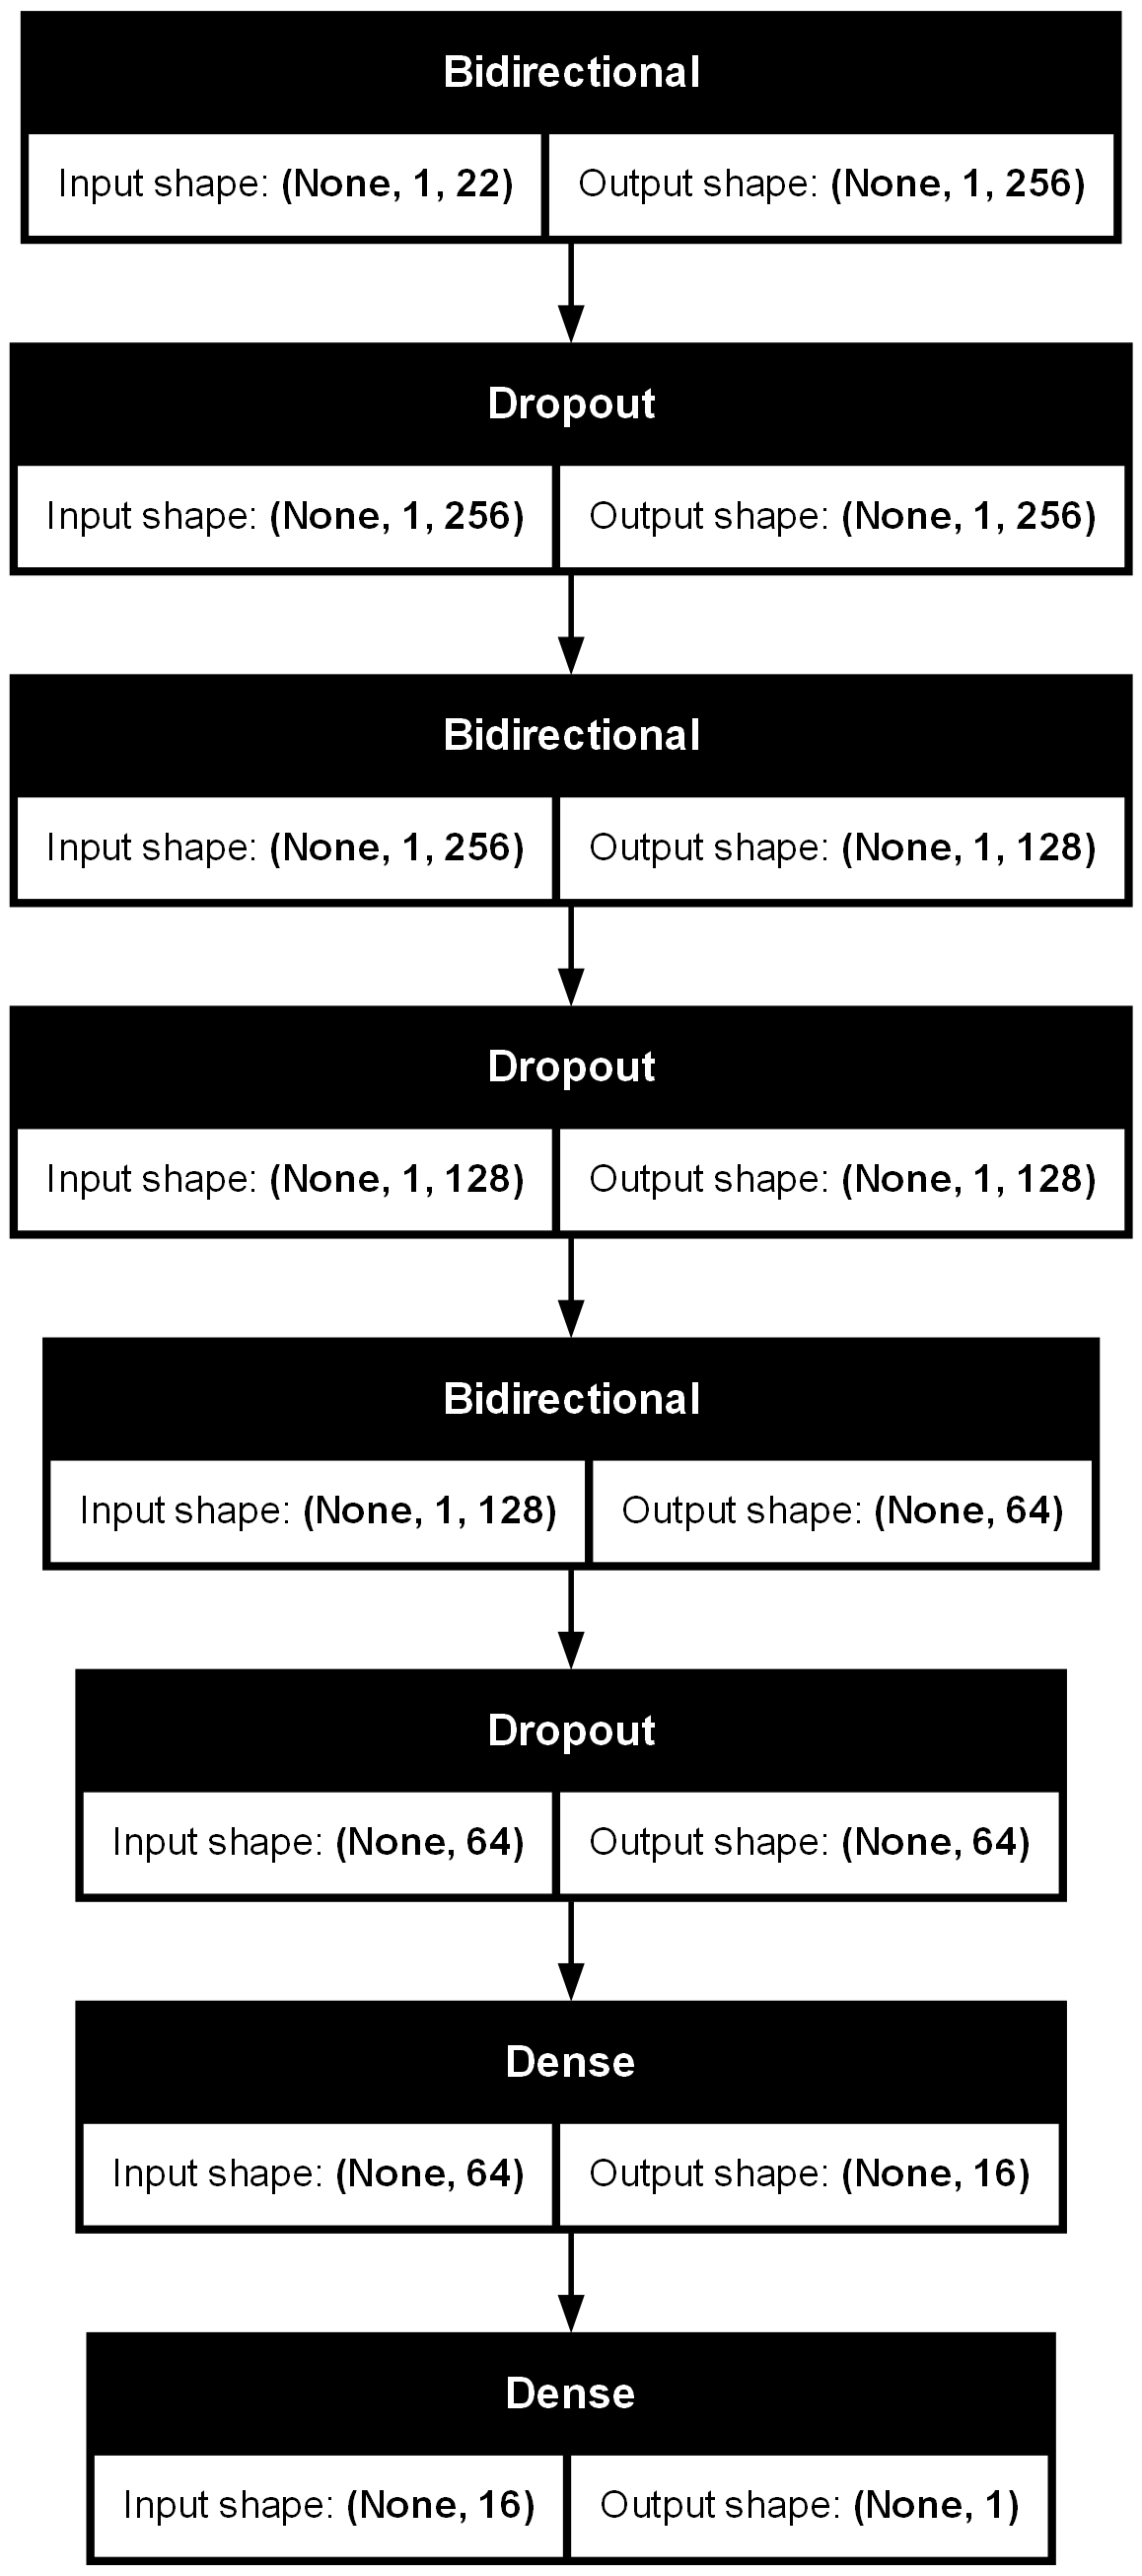

In [29]:
plot_model(model, show_shapes=True)

### Model Training

In [30]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 8.0384 - mae: 2.1473 - val_loss: 0.4691 - val_mae: 0.3358
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6119 - mae: 0.4287 - val_loss: 0.3129 - val_mae: 0.1435
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4393 - mae: 0.3325 - val_loss: 0.2759 - val_mae: 0.1792
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3869 - mae: 0.3067 - val_loss: 0.2289 - val_mae: 0.0983
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3432 - mae: 0.2930 - val_loss: 0.2106 - val_mae: 0.1283
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3307 - mae: 0.2883 - val_loss: 0.2046 - val_mae: 0.1638
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2925 - mae: 0.2710 - val_loss: 0.1757 - val_mae: 0.0943
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2710 - mae: 0.2708 - val_loss: 0.1590 - val_mae: 0.0845
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - 

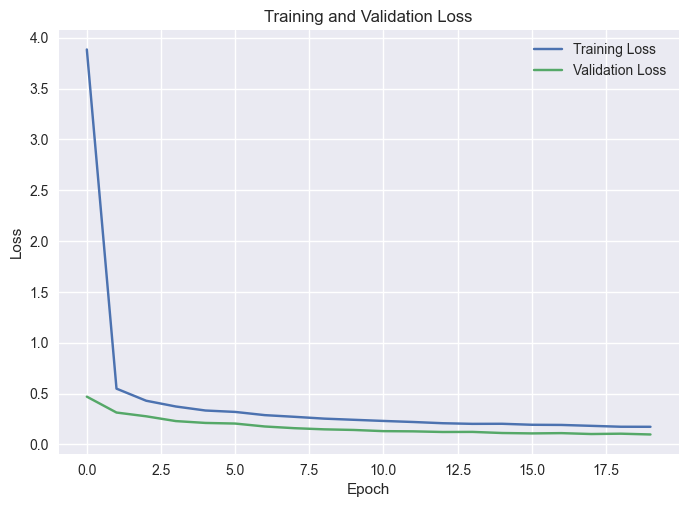

In [31]:
# Training and validation loss plots
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Visualizing Predictions

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


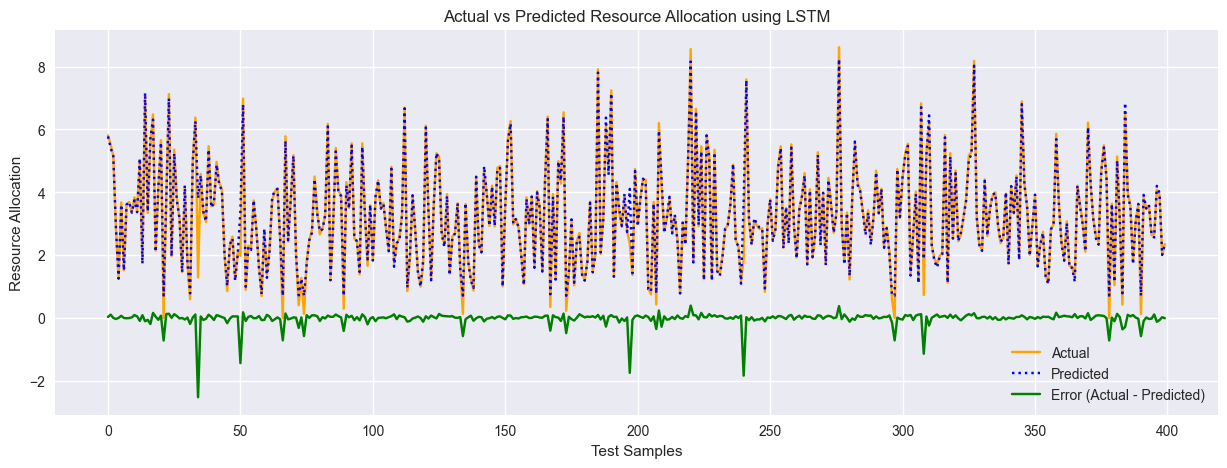

In [32]:
pred = model.predict(X_test).flatten()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:400], label='Actual', color='orange')
plt.plot(pred[:400], label='Predicted', color='blue', linestyle=':')
plt.plot(y_test[:400]-pred[:400], label='Error (Actual - Predicted)', color='green')

plt.xlabel('Test Samples')
plt.ylabel('Resource Allocation')
plt.title('Actual vs Predicted Resource Allocation using LSTM')
plt.legend()
plt.show()